Contents:

1. Module Imports
2. Reading Data into the Notebook
3. Train - Valid - Test split
4. Data Pre-processing
5. Hyperparameter tuning
6. Evaluating test set accuracy with the trained model


In [59]:
import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,matthews_corrcoef,f1_score
from sklearn.metrics import classification_report,roc_curve,roc_auc_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

%matplotlib inline

In [60]:
#Check the path to the directory where you are currently in
%pwd

'C:\\Users\\User\\Desktop\\Spring 2020\\DataScience-Hriharan\\Week-3'

In [61]:
my_path = 'C:\\Users\\User\\Desktop\\Spring 2020\\DataScience-Hriharan\\Week-3'

# II. Reading data into the notebook

In [62]:
my_df = pd.read_csv('Titanic_full.csv')
print(my_df.shape)
my_df.head(3)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# III. Train - Valid- Test Split

In [63]:
#Calculate 15% of 1309. This is about 209 rows of data. 
#So, 1309 - 209 = 1100 rows of data will remain for the
#train and valid sets which we will separate later. 200 rows of data will
#go as test set data

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,1100)

print(mydf_train_valid.shape,mydf_test.shape)

#We are going to put away the mydf_test for now. 
#We will return to it later.

(1100, 12) (209, 12)


# IV. Data Pre-processing

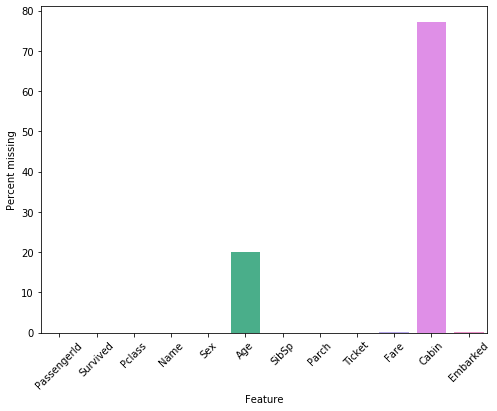

In [64]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

From the above plot, it looks like Cabin has ~80%missing values.
It would be meaningless to impute or fill in 80% values, so we drop the column.
We will impute age (which has ~ 20% missing, but we'll try to impute),
Fare, and Embarked column.These have very little missing values

We are going to preprocess this dataset in these steps--

1. Convert the entire dataframe to an array of numbers. This itself is going to happen in two steps -- (a) Convert object types and string types to category type (b) map and convert cateogries of numbers.

2. Impute or "fill in" missing values or NaNs. Here, continuous (e.g. Fare column) and categorical values are treated separately. For filling up missing continuous values, we use the median value of that column, and filling up missing categorical values, we use 0. Also, we add a separate "marker" column for both that notes whether a value has been imputed or not.

3. Finally, for a lot of the algorithms like k-NN, we scale the data to lie between 0 and 1 with mean zero and unit variance.


In [65]:
mydf_train_valid_2 = mydf_train_valid.drop("Cabin",axis = 1)
print(mydf_train_valid_2.shape)
mydf_train_valid_2.head(2)

(1100, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C


In [66]:
#Check types of each column with the dataframe info () method
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1100 non-null   int64  
 1   Survived     1100 non-null   int64  
 2   Pclass       1100 non-null   int64  
 3   Name         1100 non-null   object 
 4   Sex          1100 non-null   object 
 5   Age          881 non-null    float64
 6   SibSp        1100 non-null   int64  
 7   Parch        1100 non-null   int64  
 8   Ticket       1100 non-null   object 
 9   Fare         1099 non-null   float64
 10  Embarked     1098 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 94.7+ KB


In [67]:
'''You can see that several of the columns or features are "object" type
These need to be changed to category before we can convert those to 
mappings and numbers'''
#1 (a) Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [68]:
mydf_train_valid_3 = str_to_cat(mydf_train_valid_2)
print()

In [69]:
#Check dtypes of columns after this operation
mydf_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1100 non-null   int64   
 1   Survived     1100 non-null   int64   
 2   Pclass       1100 non-null   int64   
 3   Name         1100 non-null   category
 4   Sex          1100 non-null   category
 5   Age          881 non-null    float64 
 6   SibSp        1100 non-null   int64   
 7   Parch        1100 non-null   int64   
 8   Ticket       1100 non-null   category
 9   Fare         1099 non-null   float64 
 10  Embarked     1098 non-null   category
dtypes: category(4), float64(2), int64(5)
memory usage: 161.8 KB


In [70]:
'''Check the cateogry mapping for Embarked and Sex column. We need this
later'''
print(mydf_train_valid_3.Embarked.cat.categories)
print(mydf_train_valid_3.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


In [71]:
mydf_train_valid_4=mydf_train_valid_3.Embarked.cat.codes + 1
mydf_train_valid_4

0       3
1       1
2       3
3       3
4       3
       ..
1095    3
1096    1
1097    2
1098    3
1099    1
Length: 1100, dtype: int8

All object categories like Name, Sex, and Ticket have been converted to
Category dtype !

In [72]:
'''Define impute functions. Impute categorical NaNs with -1, 
where we add 1 to make it 0. For each 
continuous variables, we impute missing values with median values of that
column, and for every variable
where any rows were imputed, add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1
        
def mydf_imputer(my_df, feature, null_status, null_table):
    if is_numeric_dtype(feature):
        if pd.isnull(feature).sum() or (null_status in null_table):
            my_df[null_status+'_na'] = pd.isnull(feature)
            filler = null_table[null_status] if null_status in null_table else feature.median()
            my_df[null_status] = feature.fillna(filler)
            null_table[null_status] = filler
    return null_table   

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        null_table = mydf_imputer(my_df, q, p, null_table)
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

In [73]:
mydf_train_valid_4,my_table = mydf_preprocessor(mydf_train_valid_3,null_table = None)

In [74]:
mydf_train_valid_4.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
0,1,0,3,135,2,22.0,1,0,629,7.2500,3,False,False
1,2,1,1,245,1,38.0,1,0,713,71.2833,1,False,False
2,3,1,3,442,1,26.0,0,0,799,7.9250,3,False,False


In [75]:
'''Please store the null_table, category mapping separately.
We will need to process the test dataset using these values'''
my_table

{'Age': 28.0, 'Fare': 14.4583}

In [76]:
'''Now, let's separate the X and Y variables (vertical split of the 
dataframe). Here the Y column is the variable we are trying to predict, 
survived or not(0 = No, 1 = Yes)'''

Y = mydf_train_valid_4["Survived"]
X = mydf_train_valid_4.drop(["Survived"],axis = 1)

print(X.shape,Y.shape)

(1100, 12) (1100,)


In [77]:
'''Note that the different continuous variable columns of this dataframe 
have numbers in different ranges. For example, the Fare and age columns. 
For some machine learning algorithms like Decision Trees and 
their ensembles (Random Forests, for example) the above X and Y
can be directly used as input. However, for a lot of other ML algorithms 
like K nearest neighbors (KNN), we need to scale the continuous variables 
so that their values are mapped to a number between 0 and 1. 
Let's split this dataframe into continuous variable 
columns and those with categorical variables. We will leave 
the categorical variables untouched because their 
values are treated as different levels and its kind of meaningless to
scale them'''

X_cat = X[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con = X.drop(X_cat,axis = 1)
print(X_cat.shape,X_con.shape)

(1100, 10) (1100, 2)


In [78]:
'''Scale the continuous variables. To standardize (includes scaling), 
we subtract mean of that column from every value, then divide the results 
by the variable's standard deviation. There are different ways to 
standardize. Please see preprocessing under scikit-leanr page'''

scaler = preprocessing.StandardScaler().fit(X_con)
X_con_sc = pd.DataFrame(scaler.transform(X_con))
X_con_sc.columns = ["Age","Fare"]
print(X_con_sc.shape)
X_con_sc.head(2)

(1100, 2)


,Age,Fare
0,-0.574896,-0.502155
1,0.659705,0.747957


In [79]:
'''Store this scaler variable or its mean and SD, by pickling or something;
we need to use the same mean and SD scaler later while pre-processing 
the test set. Now, let's join the cateogrical and scaled continuous 
variables, back together into one dataframe'''

df_list = [X_cat,X_con_sc]
X_full = pd.concat(df_list,axis = 1)
print(X_full.shape)
X_full.head(2)

(1100, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1,3,135,2,1,0,629,3,False,False,-0.574896,-0.502155
1,2,1,245,1,1,0,713,1,False,False,0.659705,0.747957


In [80]:
'''Then, split into train and valid sets for model building 
and hyperparameter tuning, respectively !Remember, we need to 
split (horizontally the rows) X_full into train and validation sets.
We use the dataframe splitter function we defined previously.
Strictly for later use in another module, merge X and Y and store.
Save it as train data. Reason explained in module III'''

X_train,X_valid = mydf_splitter(X_full,900)
Y_train,Y_valid = mydf_splitter(Y,900)

print(X_train.shape,X_valid.shape,Y_train.shape,Y_valid.shape)


(900, 12) (200, 12) (900,) (200,)


In [81]:
'''Time for training the model and evaluating it on the validation set. 
At first, let's use the default values for the kNN hyperparameters -
n_neighbors = 3,weights = 'uniform'). KNN has more hyperparameters such as
leaf_size, metric, etc. But, these two are key hyperparamters'''

my_knn_model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',metric_params=None, n_jobs=1, n_neighbors=5, p=2,weights='uniform')
my_knn_model.fit(X_train,Y_train)

#Predict on the validation set
Y_pred = my_knn_model.predict(X_valid)

In [82]:
#checking for accuracy on train set to get isnights of overfit/underfit mode
#y_pred = knn_model.predict(x_train)
#accuracy_score(y_train,y_pred)

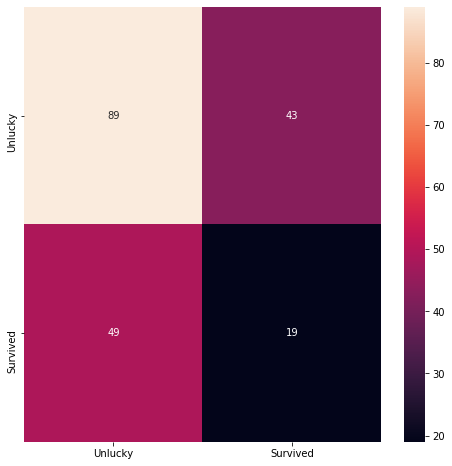

In [83]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

my_knn_cmatrix = confusion_matrix(Y_valid,Y_pred)

my_knn_df = pd.DataFrame(my_knn_cmatrix)
plt.figure(figsize = (8,8))
sns.heatmap(my_knn_df, xticklabels = ["Unlucky","Survived"],
            yticklabels = ["Unlucky","Survived"],annot = True)

In [84]:
print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),f1_score(Y_valid,Y_pred))

#An MCC of -0.0474 looks bad !We need to do model tuning or 
#hyperparameter tuning to try to make it better

0.54 -0.0474697036788388 0.29230769230769227


In [85]:
from sklearn.metrics import classification_report
scores = classification_report(Y_valid,Y_pred)
print(scores)

              precision    recall  f1-score   support

           0       0.64      0.67      0.66       132
           1       0.31      0.28      0.29        68

    accuracy                           0.54       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.53      0.54      0.53       200



# V. Hyperparameter tuning(using GridSearchCV)

In [118]:
import numpy as np
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': list(range(1,20)),
             'weights': ['uniform', 'distance'],
             'metric': ['minkowski'],
             'p': [1,2],
             'leaf_size':list(range(1,35)),
             'metric_params':[None],
             'n_jobs':[1],
             'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
             }
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5,scoring='neg_mean_squared_error')
#fit model to data
knn_gscv.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'metric': ['minkowski'], 'metric_params': [None],
                         'n_jobs': [1],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 

In [119]:
knn_gscv.best_params_

{'algorithm': 'auto',
 'leaf_size': 1,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 16,
 'p': 1,
 'weights': 'uniform'}

In [120]:
knn_gscv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=1, n_neighbors=16, p=1,
                     weights='uniform')

In [121]:
knn_gscv.best_score_

-0.3877777777777777

In [122]:
cvres = knn_gscv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.6540472290116194 {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.6540472290116194 {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.6514940095230688 {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.6514940095230688 {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.6463573143221772 {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.6540472290116194 {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.65489609014

0.6540472290116194 {'algorithm': 'auto', 'leaf_size': 11, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.6514940095230688 {'algorithm': 'auto', 'leaf_size': 11, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.6514940095230688 {'algorithm': 'auto', 'leaf_size': 11, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.6463573143221772 {'algorithm': 'auto', 'leaf_size': 11, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.6540472290116194 {'algorithm': 'auto', 'leaf_size': 11, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.6548960901462834 {'algorithm': 'auto', 'leaf_size': 11, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.65149

0.6446359868604572 {'algorithm': 'auto', 'leaf_size': 17, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
0.6342099196813482 {'algorithm': 'auto', 'leaf_size': 17, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 12, 'p': 2, 'weights': 'uniform'}
0.659123997776173 {'algorithm': 'auto', 'leaf_size': 17, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 12, 'p': 2, 'weights': 'distance'}
0.6350852961085883 {'algorithm': 'auto', 'leaf_size': 17, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
0.6472162612982533 {'algorithm': 'auto', 'leaf_size': 17, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
0.6463573143221772 {'algorithm': 'auto', 'leaf_size': 17, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
0.

0.6463573143221772 {'algorithm': 'auto', 'leaf_size': 27, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.6540472290116194 {'algorithm': 'auto', 'leaf_size': 27, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.6548960901462834 {'algorithm': 'auto', 'leaf_size': 27, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.6514940095230688 {'algorithm': 'auto', 'leaf_size': 27, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.66332495807108 {'algorithm': 'auto', 'leaf_size': 27, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.6616477747093069 {'algorithm': 'auto', 'leaf_size': 27, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.6666666

0.6514940095230688 {'algorithm': 'auto', 'leaf_size': 34, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
0.6514940095230688 {'algorithm': 'auto', 'leaf_size': 34, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.6463573143221772 {'algorithm': 'auto', 'leaf_size': 34, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.6540472290116194 {'algorithm': 'auto', 'leaf_size': 34, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.6548960901462834 {'algorithm': 'auto', 'leaf_size': 34, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.6514940095230688 {'algorithm': 'auto', 'leaf_size': 34, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.66332

0.6342099196813482 {'algorithm': 'ball_tree', 'leaf_size': 6, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 12, 'p': 2, 'weights': 'uniform'}
0.659123997776173 {'algorithm': 'ball_tree', 'leaf_size': 6, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 12, 'p': 2, 'weights': 'distance'}
0.6350852961085883 {'algorithm': 'ball_tree', 'leaf_size': 6, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
0.6472162612982533 {'algorithm': 'ball_tree', 'leaf_size': 6, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
0.6463573143221772 {'algorithm': 'ball_tree', 'leaf_size': 6, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
0.6574360974438673 {'algorithm': 'ball_tree', 'leaf_size': 6, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 2, '

0.6565905201197404 {'algorithm': 'ball_tree', 'leaf_size': 14, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
0.66332495807108 {'algorithm': 'ball_tree', 'leaf_size': 14, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
0.6531972647421808 {'algorithm': 'ball_tree', 'leaf_size': 14, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}
0.6591239977761729 {'algorithm': 'ball_tree', 'leaf_size': 14, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
0.6582805886043833 {'algorithm': 'ball_tree', 'leaf_size': 14, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.6599663291074443 {'algorithm': 'ball_tree', 'leaf_size': 14, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 1, 'w

0.6514940095230688 {'algorithm': 'ball_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
0.6463573143221772 {'algorithm': 'ball_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
0.6540472290116194 {'algorithm': 'ball_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
0.6548960901462834 {'algorithm': 'ball_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
0.6514940095230688 {'algorithm': 'ball_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.66332495807108 {'algorithm': 'ball_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 3, 'p': 1, '

0.659123997776173 {'algorithm': 'ball_tree', 'leaf_size': 29, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 12, 'p': 2, 'weights': 'distance'}
0.6350852961085883 {'algorithm': 'ball_tree', 'leaf_size': 29, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}
0.6472162612982533 {'algorithm': 'ball_tree', 'leaf_size': 29, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
0.6463573143221772 {'algorithm': 'ball_tree', 'leaf_size': 29, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
0.6574360974438673 {'algorithm': 'ball_tree', 'leaf_size': 29, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 2, 'weights': 'distance'}
0.6315765107165472 {'algorithm': 'ball_tree', 'leaf_size': 29, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 14, 'p

0.6591239977761729 {'algorithm': 'kd_tree', 'leaf_size': 2, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
0.6582805886043833 {'algorithm': 'kd_tree', 'leaf_size': 2, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.6599663291074443 {'algorithm': 'kd_tree', 'leaf_size': 2, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.669991708074726 {'algorithm': 'kd_tree', 'leaf_size': 2, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.669991708074726 {'algorithm': 'kd_tree', 'leaf_size': 2, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.6454972243679028 {'algorithm': 'kd_tree', 'leaf_size': 2, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 6, 'p': 1, 'weights': 'uniform

0.6472162612982533 {'algorithm': 'kd_tree', 'leaf_size': 8, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
0.6227180564089801 {'algorithm': 'kd_tree', 'leaf_size': 8, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 16, 'p': 1, 'weights': 'uniform'}
0.6324555320336759 {'algorithm': 'kd_tree', 'leaf_size': 8, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 16, 'p': 1, 'weights': 'distance'}
0.6315765107165472 {'algorithm': 'kd_tree', 'leaf_size': 8, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}
0.6463573143221772 {'algorithm': 'kd_tree', 'leaf_size': 8, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 16, 'p': 2, 'weights': 'distance'}
0.6298147875897061 {'algorithm': 'kd_tree', 'leaf_size': 8, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 17, 'p': 1, 'weights': 

0.660807586719967 {'algorithm': 'kd_tree', 'leaf_size': 15, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
0.6658328118479393 {'algorithm': 'kd_tree', 'leaf_size': 15, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
0.6333333333333333 {'algorithm': 'kd_tree', 'leaf_size': 15, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
0.6557438524302001 {'algorithm': 'kd_tree', 'leaf_size': 15, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
0.6454972243679028 {'algorithm': 'kd_tree', 'leaf_size': 15, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}
0.6599663291074443 {'algorithm': 'kd_tree', 'leaf_size': 15, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 2, 'weights': 'd

0.6324555320336759 {'algorithm': 'kd_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 16, 'p': 1, 'weights': 'distance'}
0.6315765107165472 {'algorithm': 'kd_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}
0.6463573143221772 {'algorithm': 'kd_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 16, 'p': 2, 'weights': 'distance'}
0.6298147875897061 {'algorithm': 'kd_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}
0.6342099196813482 {'algorithm': 'kd_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 17, 'p': 1, 'weights': 'distance'}
0.6324555320336759 {'algorithm': 'kd_tree', 'leaf_size': 23, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 17, 'p': 2, 'weig

0.6557438524302001 {'algorithm': 'kd_tree', 'leaf_size': 31, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 9, 'p': 2, 'weights': 'distance'}
0.6394442031083626 {'algorithm': 'kd_tree', 'leaf_size': 31, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
0.6506407098647712 {'algorithm': 'kd_tree', 'leaf_size': 31, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
0.6368324391514266 {'algorithm': 'kd_tree', 'leaf_size': 31, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
0.6616477747093069 {'algorithm': 'kd_tree', 'leaf_size': 31, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
0.6437735971942655 {'algorithm': 'kd_tree', 'leaf_size': 31, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 11, 'p': 1, 'weigh

0.6333333333333333 {'algorithm': 'brute', 'leaf_size': 4, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
0.6557438524302001 {'algorithm': 'brute', 'leaf_size': 4, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
0.6454972243679028 {'algorithm': 'brute', 'leaf_size': 4, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}
0.6599663291074443 {'algorithm': 'brute', 'leaf_size': 4, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
0.6463573143221771 {'algorithm': 'brute', 'leaf_size': 4, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
0.6548960901462834 {'algorithm': 'brute', 'leaf_size': 4, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
0.65234

0.6472162612982533 {'algorithm': 'brute', 'leaf_size': 7, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 1, 'weights': 'distance'}
0.6463573143221772 {'algorithm': 'brute', 'leaf_size': 7, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 2, 'weights': 'uniform'}
0.6574360974438673 {'algorithm': 'brute', 'leaf_size': 7, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 13, 'p': 2, 'weights': 'distance'}
0.6315765107165472 {'algorithm': 'brute', 'leaf_size': 7, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 14, 'p': 1, 'weights': 'uniform'}
0.6437735971942655 {'algorithm': 'brute', 'leaf_size': 7, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 14, 'p': 1, 'weights': 'distance'}
0.6411794687223782 {'algorithm': 'brute', 'leaf_size': 7, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 14, 'p': 2, 'weights': 'uniform'}
0

0.660807586719967 {'algorithm': 'brute', 'leaf_size': 16, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
0.6658328118479393 {'algorithm': 'brute', 'leaf_size': 16, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
0.6333333333333333 {'algorithm': 'brute', 'leaf_size': 16, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}
0.6557438524302001 {'algorithm': 'brute', 'leaf_size': 16, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
0.6454972243679028 {'algorithm': 'brute', 'leaf_size': 16, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 2, 'weights': 'uniform'}
0.6599663291074443 {'algorithm': 'brute', 'leaf_size': 16, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
0.

0.6514940095230688 {'algorithm': 'brute', 'leaf_size': 24, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
0.66332495807108 {'algorithm': 'brute', 'leaf_size': 24, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.6616477747093069 {'algorithm': 'brute', 'leaf_size': 24, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.6666666666666667 {'algorithm': 'brute', 'leaf_size': 24, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.6666666666666667 {'algorithm': 'brute', 'leaf_size': 24, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.6565905201197404 {'algorithm': 'brute', 'leaf_size': 24, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}
0.6

0.6280481227138924 {'algorithm': 'brute', 'leaf_size': 33, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 19, 'p': 1, 'weights': 'distance'}
0.6253887679764573 {'algorithm': 'brute', 'leaf_size': 33, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 19, 'p': 2, 'weights': 'uniform'}
0.6368324391514266 {'algorithm': 'brute', 'leaf_size': 33, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 19, 'p': 2, 'weights': 'distance'}
0.6540472290116194 {'algorithm': 'brute', 'leaf_size': 34, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.6540472290116194 {'algorithm': 'brute', 'leaf_size': 34, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
0.6514940095230688 {'algorithm': 'brute', 'leaf_size': 34, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': 1, 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'

# 1# Fitting best parameters to the KNN model

In [86]:
#Fitting the best parameters got above using GridSearchCV


knn_model_fin = KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',metric_params=None, n_jobs=1, n_neighbors=16, p=1,weights='uniform')
knn_model_fin.fit(X_full,Y)
#knn_model_fin.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=1, n_neighbors=16, p=1,
                     weights='uniform')

In [87]:
#Observing results on the validation set
Y_pred = knn_model_fin.predict(X_valid)

print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),f1_score(Y_valid,Y_pred))

0.68 0.1766716274149649 0.15789473684210525


In [88]:
scores = classification_report(Y_valid,Y_pred)
print(scores)
#checked with the test set and accuracy comes out to be- 0.5645933014354066

              precision    recall  f1-score   support

           0       0.68      0.98      0.80       132
           1       0.75      0.09      0.16        68

    accuracy                           0.68       200
   macro avg       0.71      0.54      0.48       200
weighted avg       0.70      0.68      0.58       200



# Trying with intermediate value of K,metric,weight,p(euclidean/manhattan),algorithm,leaf_size

In [89]:
knn_model_fin = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',metric_params=None, n_jobs=1, n_neighbors=9, p=2,weights='uniform')
knn_model_fin.fit(X_full,Y)
#knn_model_fin.fit(X_train,Y_train)

Y_pred = knn_model_fin.predict(X_valid)

print(accuracy_score(Y_valid,Y_pred),
      matthews_corrcoef(Y_valid,Y_pred),f1_score(Y_valid,Y_pred))

#Getting better accuracy with intermediate parameters, testing it on test set

0.725 0.33681063838388786 0.3956043956043956


In [90]:
scores = classification_report(Y_valid,Y_pred)
print(scores)

              precision    recall  f1-score   support

           0       0.72      0.96      0.82       132
           1       0.78      0.26      0.40        68

    accuracy                           0.73       200
   macro avg       0.75      0.61      0.61       200
weighted avg       0.74      0.72      0.68       200



In [91]:
!mkdir knn_model
knn_model_name = 'C:\\Users\\User\\Desktop\\Spring 2020\\DataScience-Hriharan\\Week-3\\knn_model\\knn_model_final.sav'
joblib.dump(knn_model_fin,knn_model_name)

A subdirectory or file knn_model already exists.


['C:\\Users\\User\\Desktop\\Spring 2020\\DataScience-Hriharan\\Week-3\\knn_model\\knn_model_final.sav']

In [92]:
#Make sure your model has been saved !
!ls knn_model

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [93]:
# Congrats! You have saved your model!Now, let's read it back in!
knn_model_loaded = joblib.load(knn_model_name)

# VI. Evaluating test set accuracy with the trained model

In [94]:
'''Before we can apply this on the test set, we
need to pre-process the test set in exactly the same way we did the
train_valid set !!!'''

print(mydf_test.shape)
mydf_test.head(3)


(209, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,NaN,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,NaN,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,NaN,S


In [95]:
#get rid of the "cabin" column as we did before with the train_valid set
mydf_test1 = mydf_test.drop("Cabin",axis = 1)
print(mydf_test1.shape)
mydf_test1.head(3)

(209, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
1100,1101,1,3,"Delalic, Mr. Redjo",male,25.0,0,0,349250,7.8958,S
1101,1102,0,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,S
1102,1103,1,3,"Finoli, Mr. Luigi",male,NaN,0,0,SOTON/O.Q. 3101308,7.0500,S


In [96]:
'''Make sure the category codes for train and test sets are the same as 
the ones we used previously! Here, we have coded, Name, Sex, Ticket and 
embarked. Because Name and Ticket ids will not be repeated, 
we will check Sex and embarked. Checking category codes for the test set...'''

mydf_test2 = str_to_cat(mydf_test1)
mydf_test2.Sex.cat.categories

Index(['female', 'male'], dtype='object')

In [97]:
#Check for the Embarked column
mydf_test2.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

In [98]:
#Cool, this means the category codes are the same. We can proceed.
#Make sure you use the same impute values of median.
mydf_test3,my_table1 = mydf_preprocessor(mydf_test2,
                                         null_table = my_table)
print(mydf_test3.shape)
mydf_test3.head(3)

(209, 13)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_na,Fare_na
1100,1101,1,3,47,2,25.0,0,0,106,7.8958,3,False,False
1101,1102,0,3,6,2,32.0,0,0,146,22.5250,3,False,False
1102,1103,1,3,62,2,28.0,0,0,187,7.0500,3,True,False


In [99]:
my_table1

{'Age': 28.0, 'Fare': 14.4583}

In [100]:
# Now, let's split out the X and Y variables (vertical split of the dataframe)
#Remember we did this previously!

Y_t = mydf_test3["Survived"]
X_t = mydf_test3.drop(["Survived"],axis = 1)

print(X_t.shape,Y_t.shape)

(209, 12) (209,)


In [101]:
#Separate continuous and categorical variables/columns for scaling

X_cat_t = X_t[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked', 'Age_na', 'Fare_na']]
X_con_t = X_t.drop(X_cat_t,axis = 1)
print(X_cat_t.shape,X_con_t.shape)

(209, 10) (209, 2)


In [102]:
'''Scale using the training set mean and SD. This is already captured in
the scaler object we made. Else, save that in a joblib dump too to reload'''

X_con_sct = pd.DataFrame(scaler.transform(X_con_t))
X_con_sct.columns = ["Age","Fare"]
print(X_con_sct.shape)
X_con_sct.head(2)


(209, 2)


,Age,Fare
0,-0.343408,-0.489547
1,0.196729,-0.203944


In [103]:
print(X_cat_t.shape,X_con_sct.shape)

(209, 10) (209, 2)


In [104]:
#Re-index before merging
X_cat_t.reset_index(inplace = True,drop = False)

In [105]:
X_cat_t.head()

,index,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1100,1101,3,47,2,0,0,106,3,False,False
1,1101,1102,3,6,2,0,0,146,3,False,False
2,1102,1103,3,62,2,0,0,187,3,True,False
3,1103,1104,2,45,2,0,0,179,3,False,False
4,1104,1105,2,91,1,1,0,38,3,False,False


In [106]:
X_cat_t.drop("index",inplace = True,axis = 1)
X_cat_t.head(2)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na
0,1101,3,47,2,0,0,106,3,False,False
1,1102,3,6,2,0,0,146,3,False,False


In [107]:
#Merge the two sets of columns
df_list_I = [X_cat_t,X_con_sct]
X_test_I = pd.concat(df_list_I,axis = 1)
print(X_test_I.shape)
X_test_I.head(2)

(209, 12)


,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_na,Fare_na,Age,Fare
0,1101,3,47,2,0,0,106,3,False,False,-0.343408,-0.489547
1,1102,3,6,2,0,0,146,3,False,False,0.196729,-0.203944


In [108]:
#Now we are ready to test it out. Let's load the saved model first.
kNN_load = joblib.load('C:\\Users\\User\\Desktop\\Spring 2020\\DataScience-Hriharan\\Week-3\\knn_model\\knn_model_final.sav')

In [109]:
kNN_load

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=1, n_neighbors=9, p=2,
                     weights='uniform')

In [110]:
#Testing...
Y_test_pred = kNN_load.predict(X_test_I)

In [111]:
print(accuracy_score(Y_t,Y_test_pred),
      matthews_corrcoef(Y_t,Y_test_pred),f1_score(Y_t,Y_test_pred))

0.569377990430622 0.07895663661098853 0.02173913043478261


In [112]:
scores = classification_report(Y_t,Y_test_pred)
print(scores)

              precision    recall  f1-score   support

           0       0.57      1.00      0.72       118
           1       1.00      0.01      0.02        91

    accuracy                           0.57       209
   macro avg       0.78      0.51      0.37       209
weighted avg       0.76      0.57      0.42       209



In [113]:
rec, fall_out, thresholds = roc_curve(Y_t,Y_test_pred) 

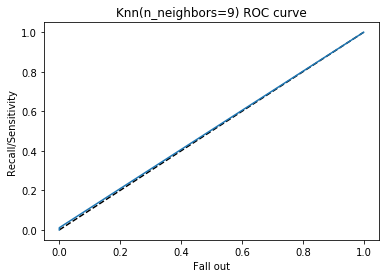

In [114]:
plt.plot([0,1],[0,1],'k--')
plt.plot(rec,fall_out, label='Knn')
plt.xlabel('Fall out')
plt.ylabel('Recall/Sensitivity')
plt.title('Knn(n_neighbors=9) ROC curve')
plt.show()

In [115]:
#Area under ROC curve
roc_auc_score(Y_t,Y_test_pred)

0.5054945054945055

In [116]:
'''We are done! Our kNN model is not doing great on this dataset but
we learnt how to properly use machine learning. Soon, we will learn
how to use other algorithms to get better performance'''

'We are done! Our kNN model is not doing great on this dataset but\nwe learnt how to properly use machine learning. Soon, we will learn\nhow to use other algorithms to get better performance'

In [117]:
'''Write out full train_valid and test dataframes for later use
in module III'''
X_full["Survived"] = Y
X_test_I["Survived"] = Y_t

print(X_full.shape)
print(X_test_I.shape)

(1100, 13)
(209, 13)


# Cons of KNN Model

The disadvantages of KNN allgorithims are as follows:

1. Does not work well with large dataset: In large datasets, the cost of calculating the distance between the new point and each existing points is huge which degrades the performance of the algorithm.

2. Does not work well with high dimensions: The KNN algorithm doesn't work well with high dimensional data because with large number of dimensions, it becomes difficult for the algorithm to calculate the distance in each dimension.

3. Need feature scaling: We need to do feature scaling (standardization and normalization) before applying KNN algorithm to any dataset. If we don't do so, KNN may generate wrong predictions.

4. Sensitive to noisy data, missing values and outliers: KNN is sensitive to noise in the dataset. We need to manually impute missing values and remove outliers.
    
5. The algorithm gets significantly slower as the number of examples and/or predictors/independent variables increase.

6. The “prediction” step in K-NN is relatively expensive. Each time we want to make a prediction, K-NN is searching for the nearest neighbor(s) in the entire training set.

7. There is no training time in K-NN. Whereas, Most of the algorithm(such as the logistic regression) learns its model weights (parameters) during training time.

8. KNN makes no assumptions about the functional form of the problem being solved. As such KNN is referred to as a non-parametric machine learning algorithm.
    
9. In terms of time and memory, the testing phase of K-nearest neighbor classification is slower and costlier. It requires large memory for storing the entire training dataset for prediction.